# Classifying Damage Level Disaster-Induced Images Via Computer Vision


https://www.overleaf.com/project/662998cb25dcfcdb03e5d57a

Shirley Li, Kofi Mireku, Brent Thorne

Data200S, UC Berkeley MSSE

## Import Libraries and Setup Environment

In [1]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from utils import read_files_from_zip, data2pd, show_balance, load_model_data, save_model_data

2024-04-28 09:06:13.076723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configure system type
COLAB = False

# Set data and system paths
if COLAB:
  import sys
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  data_dir = f'{path}/Data'
  sys.path.insert(0, f'{path}/Source') # for colab to see local libraries
else:
  data_dir = f'../Data'

# Set Date Source
data_file = f'{data_dir}/sp24_grad_project_data.zip'

In [3]:
%%time

# Pickle out data to speed this up
train_df, test_df = [], []
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/train_df.pkl') 
    & os.path.isfile(f'{data_dir}/test_df.pkl')
):
    train_df = pd.read_pickle(f'{data_dir}/train_df.pkl')
    test_df = pd.read_pickle(f'{data_dir}/test_df.pkl')
else:
    # Load Test Images
    test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')
    
    # Load Train Images and Labels
    train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
    train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')
    
    # Convert to Dataframe
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

    # Pickle DataFrame
    train_df.to_pickle(f'{data_dir}/train_df.pkl')
    test_df.to_pickle(f'{data_dir}/test_df.pkl')
    
    # Clean up
    del(test_data_images)
    del(train_data_images)
    del(train_data_labels)

CPU times: user 577 ms, sys: 599 ms, total: 1.18 s
Wall time: 2.03 s


## Feature Engineering, Task A 

In [4]:
# Select Dataset for Disaster Type Classification
train_type_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) ] # & (train_df.label != 0)]
test_type_df = test_df[((test_df.type == 'fire') | (test_df.type == 'flood')) ] # & (test_df.label != 0)]
show_balance(train_type_df)

# Encode labels
def encode_label(type_df):
    type_df = type_df.copy()
    type_df['old_label'] = type_df['label']
    type_df['label'] = type_df[['type','old_label']].apply(
            lambda df: (df['old_label']+1) if df['type']=='fire' else -(df['old_label']), axis=1).astype('int')+ 3 
    return type_df
    
train_type_df = encode_label(train_type_df)

show_balance(train_type_df)
train_type_df.shape, test_type_df.shape

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   4        7204
       7        1064
       5          69
       6          43
flood  3        6734
       2         114
       1          97
       0          59
Name: count, dtype: int64

((15384, 5), (3847, 3))

In [5]:
# Verify class labels
unique_labels = np.unique(train_type_df['label']) #+3
#expected_indices = np.arange(7)  # Indices for 7 classes (-3 to 3)
expected_indices = np.arange(8)

if not np.array_equal(unique_labels, expected_indices):
    print("Class labels do not match expected indices. Please verify your labels.")

In [6]:
unique_labels, expected_indices

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

## Model Task A

see also: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [7]:
train_type_df.columns

Index(['index', 'type', 'image', 'label', 'old_label'], dtype='object')

In [8]:
from tensorflow.keras import backend
backend.clear_session()  # clear model

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
#from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120 # Set image size

# Load Our DataFrame
df = train_type_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe['image']):
        img_array = tf.image.resize(img_array, (SIZE, SIZE))  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(np.expand_dims(img_array, axis=0), verbose=0)
        features.append(bottleneck_feature.flatten())
    return np.array(features)

train_features, val_features = [],[]
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/task_A_train_features.npy') 
    & os.path.isfile(f'{data_dir}/task_A_val_features.npy')
):
    train_features = np.load(f'{data_dir}/task_A_train_features.npy')
    val_features = np.load(f'{data_dir}/task_A_val_features.npy')
else:
    train_features = extract_bottleneck_features(m_train_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f'{data_dir}/task_A_train_features.npy', train_features)
    np.save(f'{data_dir}/task_A_val_features.npy', val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.01)),
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.0001)),
model.add(Dense(8, activation='softmax'))  # 8 classes 

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights for imbalanced labels
train_classes = m_train_df['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = 'task_A_vgg16_model_dropout'
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(train_features, m_train_df['label'], validation_data=(val_features, m_val_df['label']),
          epochs=10, batch_size=128, class_weight=class_weights_dict)
    # Save, one and done.
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)

../Data/models/task_A_vgg16_model_dropout
../Data/models/task_A_vgg16_model_dropout/history.pkl
Gherkin injested.


In [10]:
# Save model and feature weights
FREEZE = False
if FREEZE:
    model_name = 'task_A_vgg16_model'
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)
    np.save(f'{data_dir}/task_A_train_features.npy', train_features)
    np.save(f'{data_dir}/task_A_test_features.npy', test_features)
    np.save(f'{data_dir}/task_A_val_features.npy', val_features)

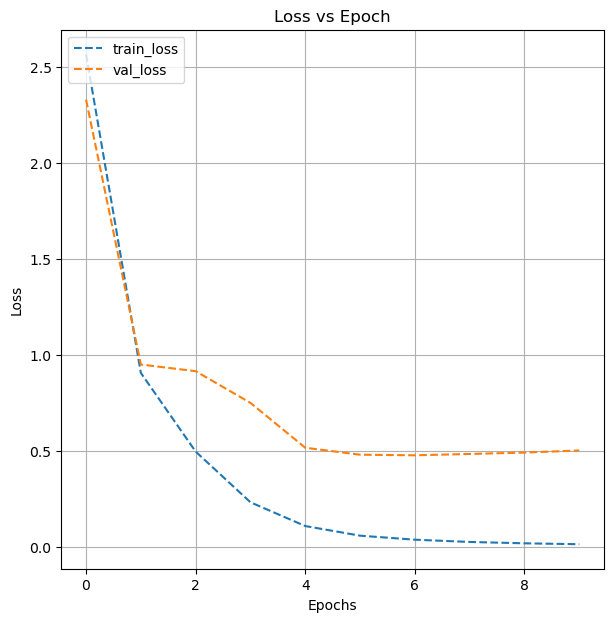

In [11]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history["loss"], label = "train_loss", ls = '--')
    plt.plot(np.arange(0, N), history["val_loss"], label = "val_loss", ls = '--')
    #plt.yscale('log')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()
    
plot_loss(model_history)

In [12]:
#train_features = np.load(f'{data_dir}/train_features.npy')
#val_features = np.load(f'{data_dir}/val_features.npy')
train_features.shape, val_features.shape

((12307, 4608), (3077, 4608))

## Prediction Task A

In [13]:
test_features = []
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/task_A_test_features.npy') 
):
    test_features = np.load(f'{data_dir}/task_A_test_features.npy')

else:
    test_features = extract_bottleneck_features(test_type_df)
    np.save(f'{data_dir}/task_A_test_features.npy', test_features)

In [14]:
# Evaluate the model on test data 
Y_pred = model.predict(test_features)

121/121 [==============================] - 1s 4ms/step


In [15]:
test_features.shape, Y_pred.shape

((3847, 4608), (3847, 8))

In [16]:
Y_pred.min(), Y_pred.max()

(8.6899223e-35, 1.0)

In [17]:
def custom_activation(y):
    return np.where(y > 3.5, 1, 0)

#np.unique(np.argmax(Y_pred, axis=1))
prediction = custom_activation(np.argmax(Y_pred, axis=1))

Y_pred_out = pd.DataFrame(prediction, columns=['pred'])
Y_pred_out.to_csv(f'{data_dir}/test_images_flooding-fire_predictions.csv', index=False)

In [18]:
Y_pred_out.shape

(3847, 1)

In [19]:
np.sum(Y_pred_out, axis=0) # 0.9586690927995841

pred    2087
dtype: int64

In [20]:
2094/3847

0.5443202495451

In [21]:
Y_pred = model.predict(val_features)
#Y_pred = model.predict(train_features)
Y_pred = custom_activation(np.argmax(Y_pred, axis=1))
np.sum(Y_pred, axis=0)/len(Y_pred)

97/97 [==============================] - 0s 5ms/step


0.5485862853428665

In [22]:
Y_actual = custom_activation(m_val_df['label'].to_numpy())
#Y_actual = custom_activation(m_train_df['label'].to_numpy())

In [23]:
sum(Y_pred==Y_actual)/ len(Y_actual)

0.9519012024699383

## Model Evaluation, Task A

Add detail!!!

## Feature Engineering, Task B

In [24]:
# Select Dataset for Disaster Leve Classification
train_level_df = train_df[(train_df.type == 'hurricane') ] 
test_level_df = test_df[(test_df.type == 'hurricane') ] 
show_balance(train_level_df)

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [25]:
train_level_df.type.unique()

array(['hurricane'], dtype=object)

In [26]:
train_level_df.columns

Index(['index', 'type', 'image', 'label'], dtype='object')

In [27]:
backend.clear_session()  # clear model

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
#from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120 # Set image size

# Load Our DataFrame
df = train_level_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe['image']):
        img_array = tf.image.resize(img_array, (SIZE, SIZE))  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(np.expand_dims(img_array, axis=0), verbose=0)
        features.append(bottleneck_feature.flatten())
    return np.array(features)

train_features, val_features = [],[]
if (
    os.path.exists(data_dir) 
    & os.path.isfile(f'{data_dir}/task_B_train_features.npy') 
    & os.path.isfile(f'{data_dir}/task_B_test_features.npy')
    & os.path.isfile(f'{data_dir}/task_B_val_features.npy')
):
    train_features = np.load(f'{data_dir}/task_B_train_features.npy')
    test_features = np.load(f'{data_dir}/task_B_test_features.npy')
    val_features = np.load(f'{data_dir}/task_B_val_features.npy')
else: #FIXME!!
    m_test_df = test_level_df
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(m_test_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f'{data_dir}/task_B_train_features.npy', train_features)
    np.save(f'{data_dir}/task_B_test_features.npy', test_features)
    np.save(f'{data_dir}/task_B_val_features.npy', val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.01)),
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.0001)),
model.add(Dense(4, activation='softmax'))  # 4 classes 

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights for imbalanced labels
train_classes = m_train_df['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = 'task_B_vgg16_model_dropout'
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(train_features, m_train_df['label'].astype(float), validation_data=(val_features, m_val_df['label'].astype(float)),
          epochs=11, batch_size=128, class_weight=class_weights_dict)

    # Save, one and done.
    save_model_data(model_name, model, model_history, 'trained on weighted labels', path=data_dir)

../Data/models/task_B_vgg16_model_dropout
../Data/models/task_B_vgg16_model_dropout/history.pkl
Gherkin injested.


In [29]:
# Evaluate the model on test data 
Y_pred = model.predict(test_features)

88/88 [==============================] - 0s 5ms/step


In [38]:
def custom_activation(y):
    return np.argmax(y, axis=1)

prediction = custom_activation(Y_pred) # 0.53241 %

Y_pred_out = pd.DataFrame(prediction, columns=['pred'])
Y_pred_out.to_csv(f'{data_dir}/test_images_hurricane-matthew_predictions.csv', index=False)

In [39]:
Y_pred.min(),Y_pred.max(), Y_pred.shape

(9.996386e-20, 1.0, (2788, 4))

In [40]:
Y_pred_out.pred.to_numpy()

array([0, 0, 1, ..., 1, 3, 1])

In [43]:
Y_pred = model.predict(val_features)
Y_pred = custom_activation(Y_pred)

70/70 [==============================] - 0s 4ms/step


In [53]:
Y_actual =  m_val_df['label'].to_numpy()

In [54]:
sum(Y_pred==Y_actual)/ len(Y_actual)

0.5544598834603317

# Model Evaluation, Task B

Add detail!!!